## Import packages

In [34]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [35]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [36]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [37]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [38]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [39]:
lower = np.array([0.1125, 0.65])
upper = np.array([0.1275, 0.85])
prior = priors.Uniform(lower, upper)

In [40]:
theta_fiducial = np.array([0.1197, 0.76])

In [41]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts
#N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [42]:
np.round(N_counts).astype(int)

array([20138, 61593, 79216, 70514, 50062,  2667,  6241,  5835,  3609,
        1705,   122,   176,    93,    30,     7])

In [43]:
t1 = time.process_time()
N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 0.46629676799989284


In [44]:
N_counts

array([20104, 61296, 78932, 70436, 50010,  2619,  6222,  5741,  3576,
        1761,   103,   162,    78,    43,     8])

## Version 2

(1) Compute fiducial number of counts N for different redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from joint redshift-mass distribution

(3) Create mock catalogue

In [45]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_2 as n_counts_simulator_2

In [46]:
importlib.reload(n_counts_simulator_2)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_2.py'>

In [47]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins_3 as n_counts_simulator_3
N_countsSimulator3 = n_counts_simulator_3.Model(log10masses, z_min, z_max)

In [48]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_small_z_bins as n_counts_simulator_4
N_countsSimulator4 = n_counts_simulator_4.Model(log10masses, z_min, z_max)

In [49]:
log10masses = np.linspace(14, 15.5, num = 2)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [50]:
N_countsSimulator2 = n_counts_simulator_2.Model(log10masses, z_min, z_max)
N_by_z = N_countsSimulator2.N_counts[0]
N_by_z.astype(int)

array([22926, 68010, 85143, 74152, 51774])

In [51]:
cosmo_ccl = N_countsSimulator2.cosmo(theta_fiducial)

In [52]:
t1 = time.process_time()
N_sims = N_countsSimulator2.simulation(theta_fiducial, 4)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 11.223023867000165


In [53]:
N_sims

array([20126, 62419, 78960, 70743, 49782,  2757,  6393,  5880,  3618,
        1736,   132,   170,    85,    28,     4])

In [54]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator2.simulation(theta, seed)

simulator_args = None

In [55]:
def compressor(data, compressor_args):
    return data
compressor_args=None

In [56]:
N_counts1 = np.load('N_counts1.npy')
N_counts2 = np.load('N_counts2.npy')
N_counts3 = np.load('N_counts3.npy')

In [59]:
N_counts1 = []
N_counts2 = []
for i in range(100):
    N_counts1.append(N_countsSimulator.simulation(theta_fiducial, i))
    N_counts2.append(N_countsSimulator2.simulation(theta_fiducial, i))

In [30]:
N_counts4 = []

for i in range(100):
    N_counts4.append(N_countsSimulator4.simulation(theta_fiducial, i))


In [31]:
N_counts4 = np.array(N_counts4)

In [66]:
np.save('N_counts1.npy', np.array(N_counts1))
np.save('N_counts2.npy', np.array(N_counts2))
np.save('N_counts3.npy', np.array(N_counts3))

In [67]:
N_counts1 = np.array(N_counts1)
N_counts2 = np.array(N_counts2)
N_counts3 = np.array(N_counts3)

In [143]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_change_steps as n_counts_simulator_5


In [141]:
importlib.reload(n_counts_simulator_5)
N_countsSimulator_trial = n_counts_simulator_5.Model(log10masses, z_min, z_max)

In [77]:
# 1000 X 5000 - N_counts5 - ok-ish
t1 = time.process_time()
N_sims = N_countsSimulator5.simulation(theta_fiducial, 4)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.31185282299998107
time to create a catalogue: 5.902327183000125
time to bin a catalogue: 0.002031057000067449
time per 1 sim: 6.21660666799994


In [80]:
# 500 X 5000 <-- not good
t1 = time.process_time()
N_sims = N_countsSimulator5.simulation(theta_fiducial, 4)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.3194807770000807
time to create a catalogue: 2.9313885239998854
time to bin a catalogue: 0.002033113999914349
time per 1 sim: 3.2533110960000613


In [97]:
# 500 X 10000 <-- not too good, N_counts6
t1 = time.process_time()
N_sims = N_countsSimulator_trial.simulation(theta_fiducial, 4, True)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.3140972740002326
time to create a catalogue: 5.533046233999812
time to bin a catalogue: 0.0020989160002500284
time per 1 sim: 5.8498420569999325


In [106]:
# 500 X 20000 <-- looks ok, N_counts7
t1 = time.process_time()
N_sims = N_countsSimulator_trial.simulation(theta_fiducial, 4, True)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.31472948300006465
time to create a catalogue: 10.36165066500007
time to bin a catalogue: 0.0028360259998407855
time per 1 sim: 10.6799554549998


In [116]:
# 1000 X 20000 <-- looks good, N_counts8
t1 = time.process_time()
N_sims = N_countsSimulator_trial.simulation(theta_fiducial, 4, True)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.3158179410002049
time to create a catalogue: 20.596164577999843
time to bin a catalogue: 0.0023140889998103376
time per 1 sim: 20.914877845999854


In [142]:
# 2000 X 10000 <-- looks v good, N_counts9
t1 = time.process_time()
N_sims = N_countsSimulator_trial.simulation(theta_fiducial, 4, True)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.31636060700111557
time to create a catalogue: 21.464744408000115
time to bin a catalogue: 0.0022743570007150993
time per 1 sim: 21.78398542100149


In [131]:
# 5000 X 1000 <-- 
t1 = time.process_time()
N_sims = N_countsSimulator_trial.simulation(theta_fiducial, 4, True)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time to compute true counts: 0.31639947199983
time to create a catalogue: 8.02962128299987
time to bin a catalogue: 0.002004996998948627
time per 1 sim: 8.348521705000167


In [132]:
N_sims

array([20176, 62402, 78925, 70732, 49761,  2713,  6385,  5901,  3626,
        1753,   126,   195,    99,    31,     8])

In [133]:
N_counts10 = []

for i in range(100):
    N_counts10.append(N_countsSimulator_trial.simulation(theta_fiducial, i))


In [134]:
N_counts10 = np.array(N_counts10)

In [128]:
np.save('N_counts10.npy', np.array(N_counts10))

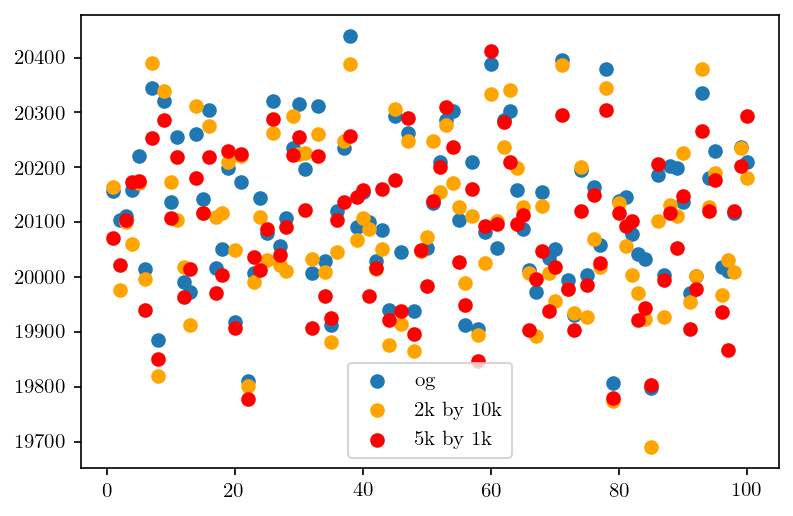

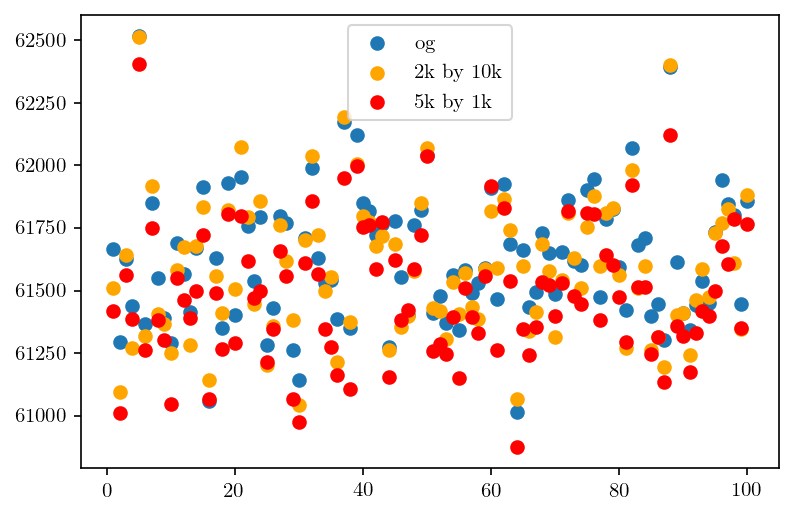

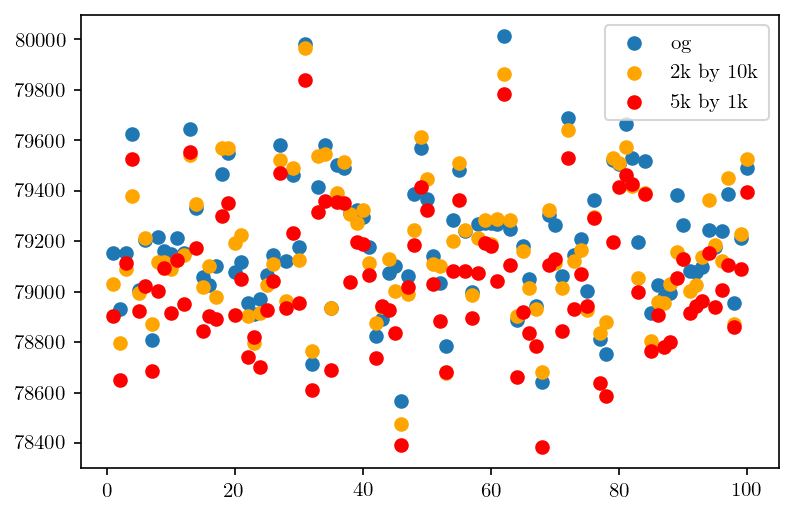

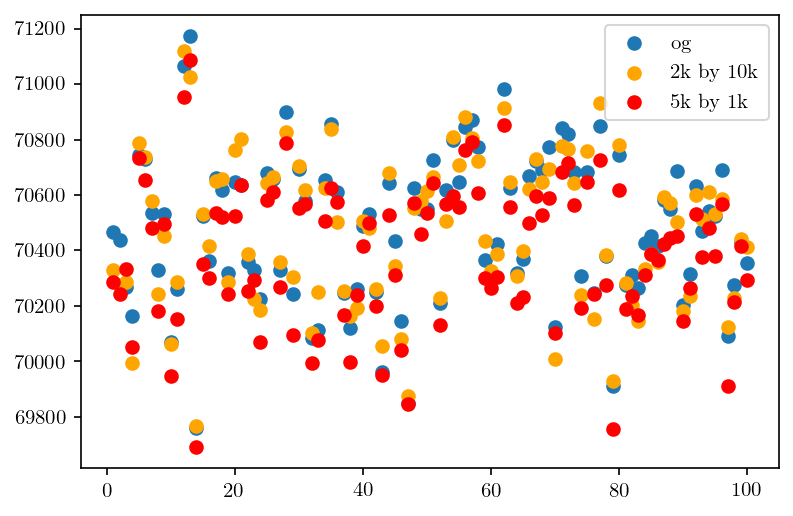

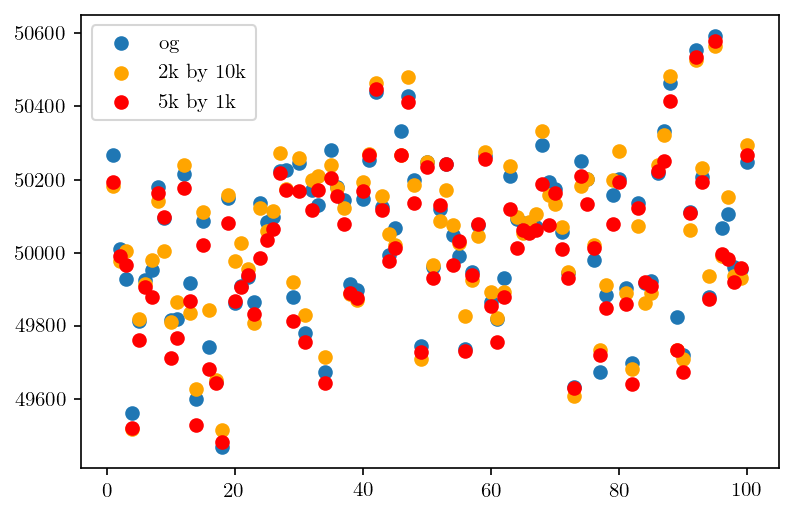

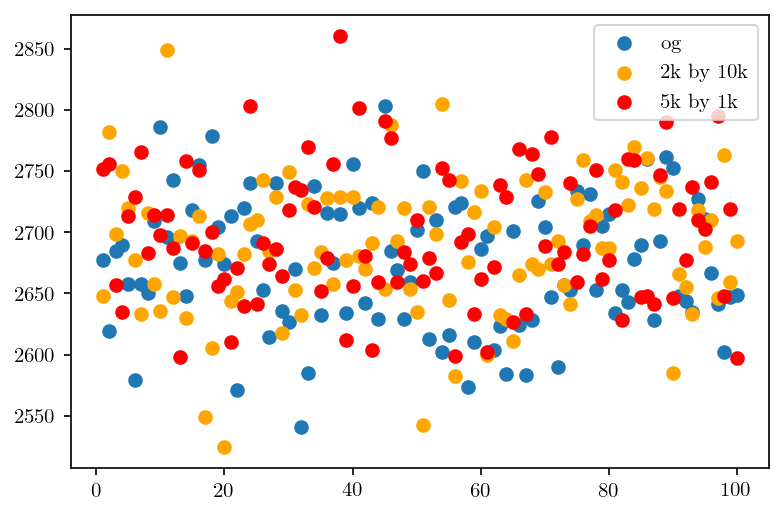

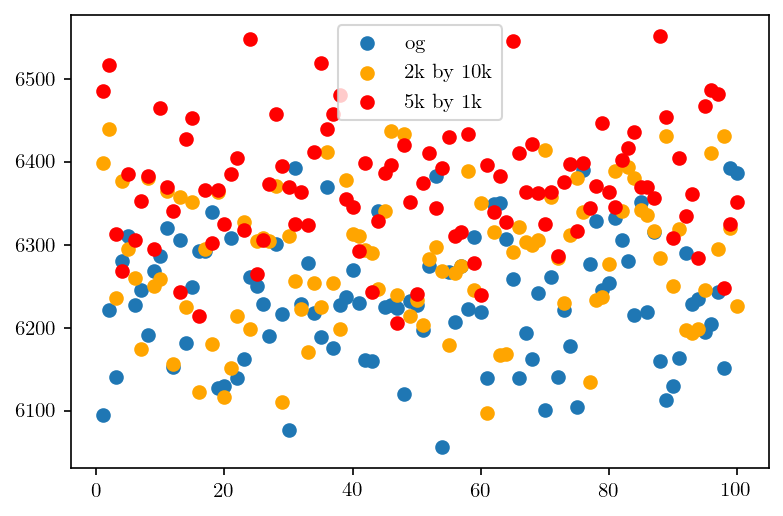

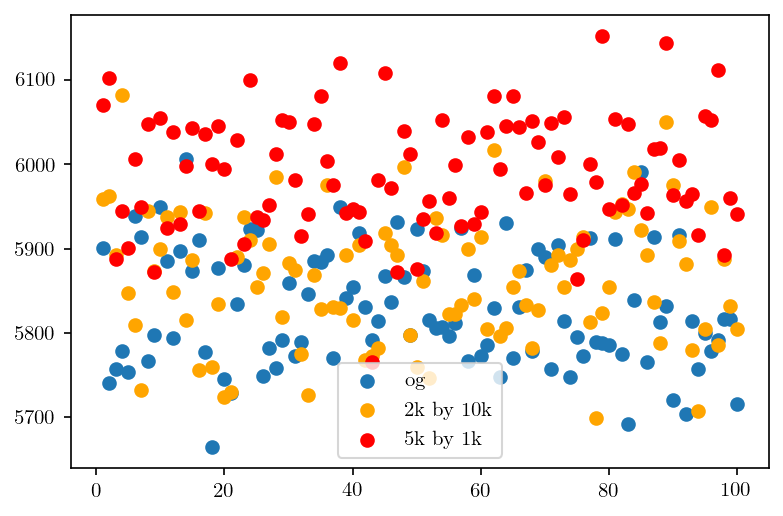

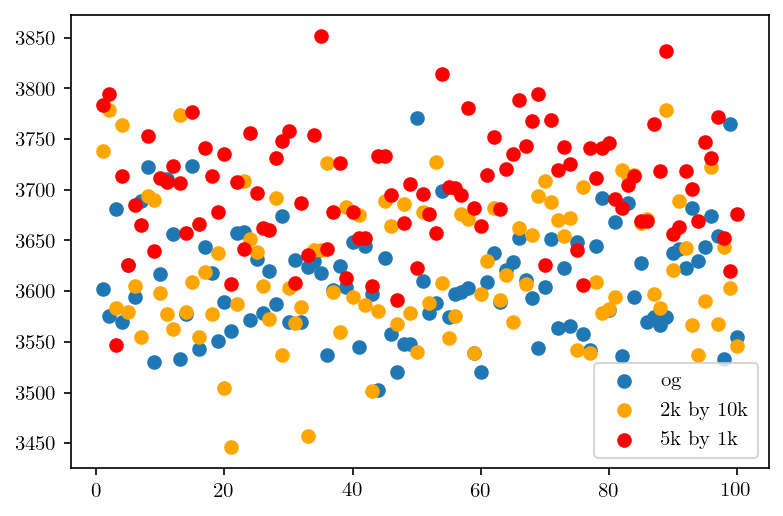

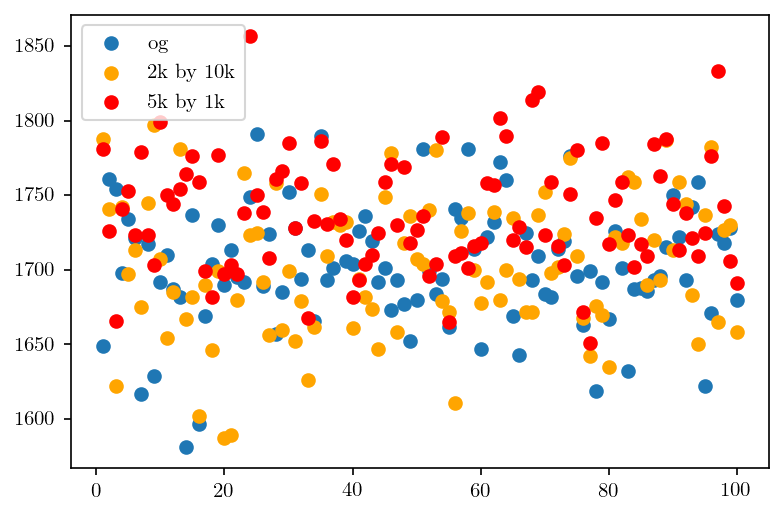

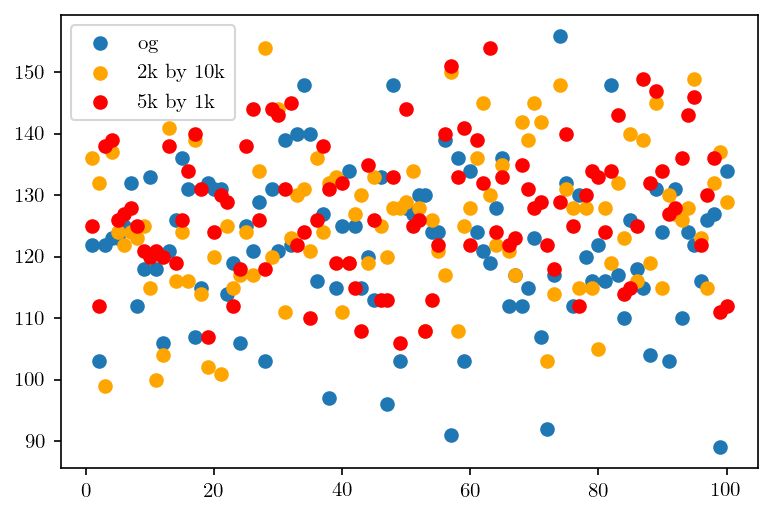

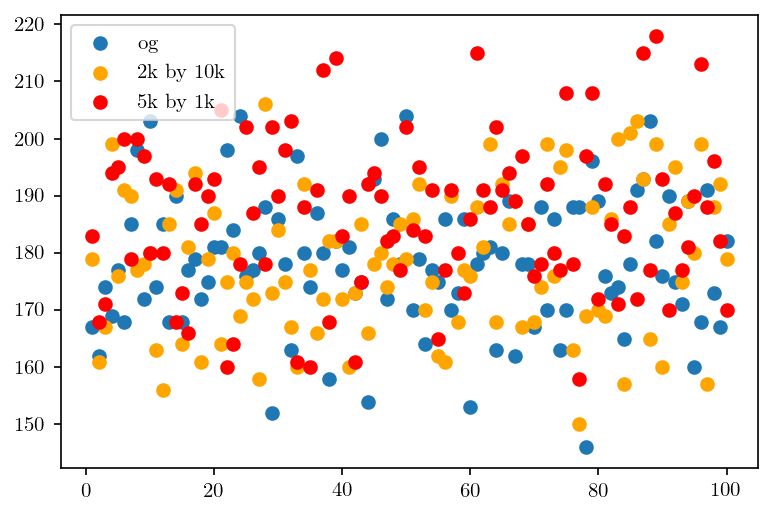

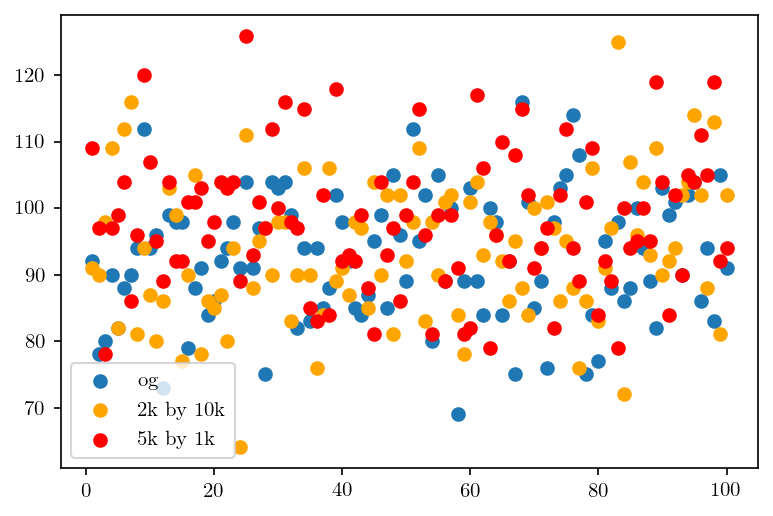

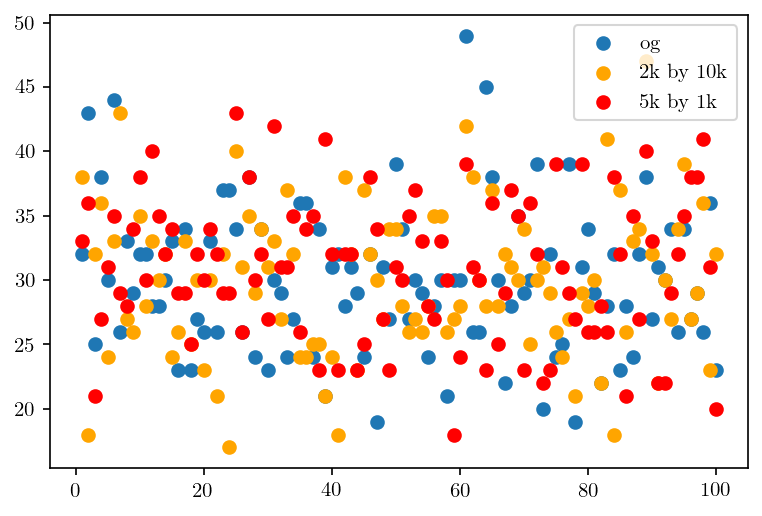

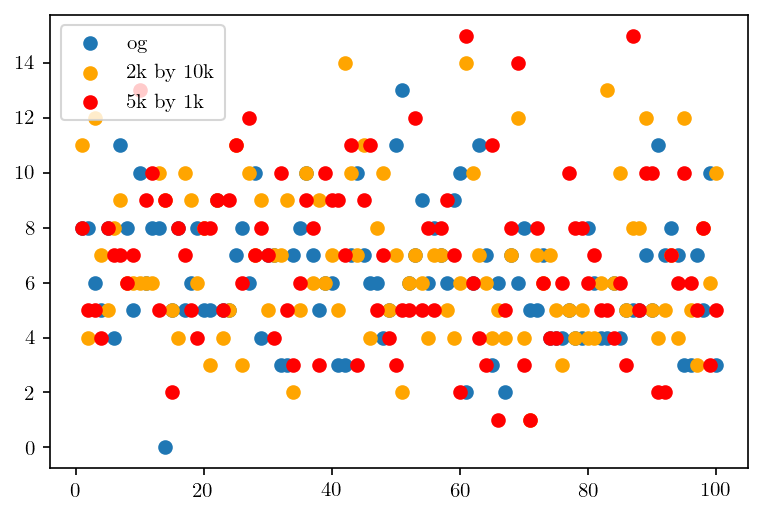

In [136]:
seeds = np.linspace(1, 100, num = 100)
for i in range(N_counts1.shape[1]):
    plt.figure()
    plt.scatter(seeds, N_counts1[:, i], label = 'og')
    #plt.scatter(seeds, N_counts2[:, i], label = '1k by 10k', c = 'g')
    plt.scatter(seeds, N_counts9[:, i], label = '2k by 10k', c = 'orange')
    plt.scatter(seeds, N_counts10[:, i], label = '5k by 1k', c = 'r')
    plt.legend(loc = 'best')

In [138]:
### different theta
theta_1 = np.array([0.122, 0.73])

In [139]:
N_countsSimulator.simulation(theta_1, 1)

array([18457, 54255, 66926, 56889, 38260,  2178,  4889,  4202,  2424,
        1106,    69,   100,    41,    24,     4])

In [148]:
N_counts_th_1 = []
N_counts_th_2 = []
for i in range(100):
    N_counts_th_1.append(N_countsSimulator.simulation(theta_1, i))
    N_counts_th_2.append(N_countsSimulator_trial.simulation(theta_1, i))
    if i%10 == 0:
        print(i)
        
N_counts_th_1 = np.array(N_counts_th_1)
N_counts_th_2 = np.array(N_counts_th_2)

0
10
20
30
40
50
60
70
80
90


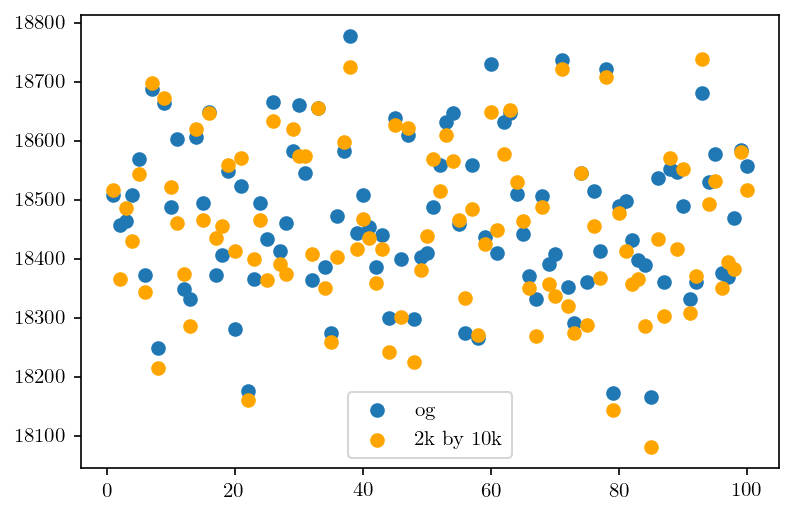

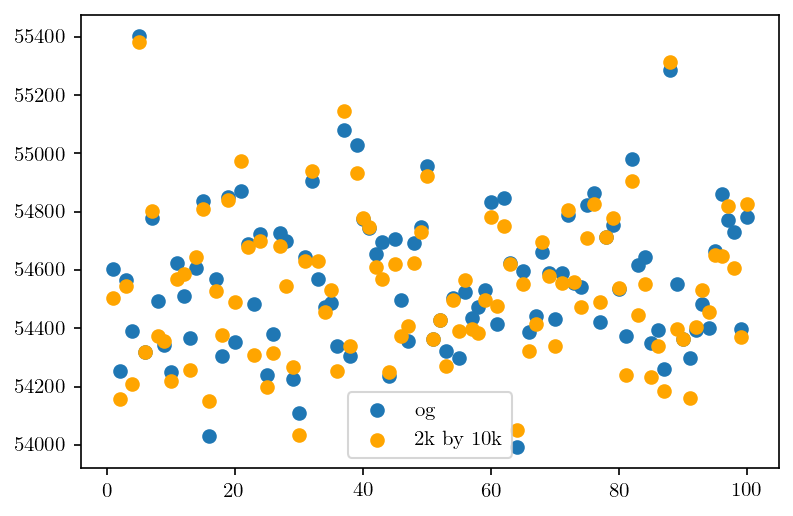

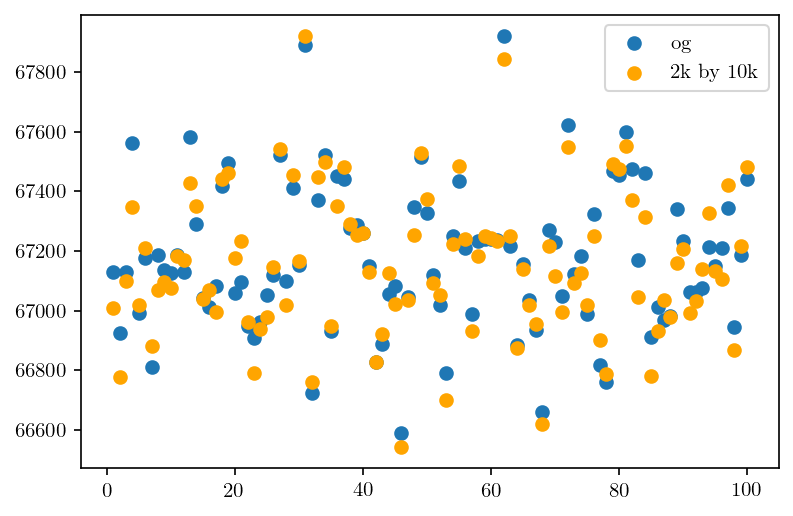

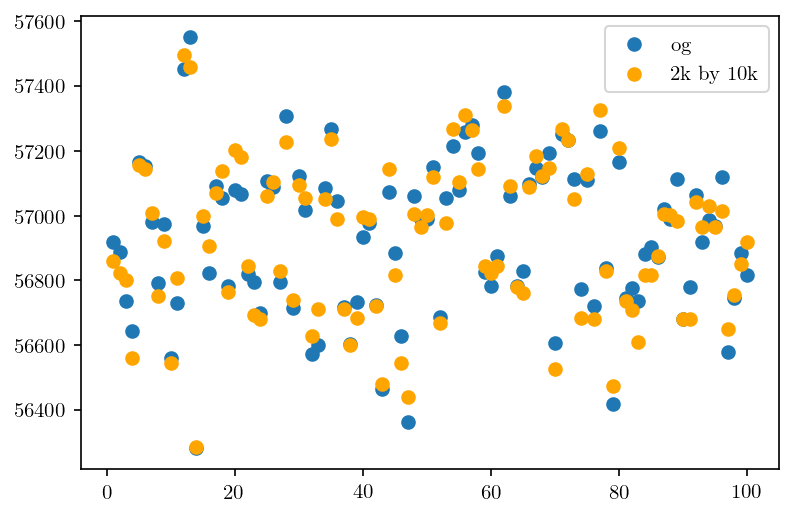

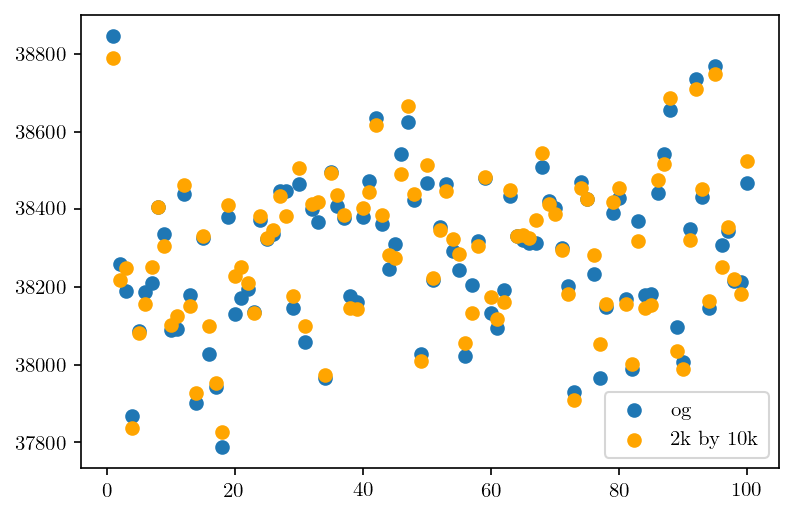

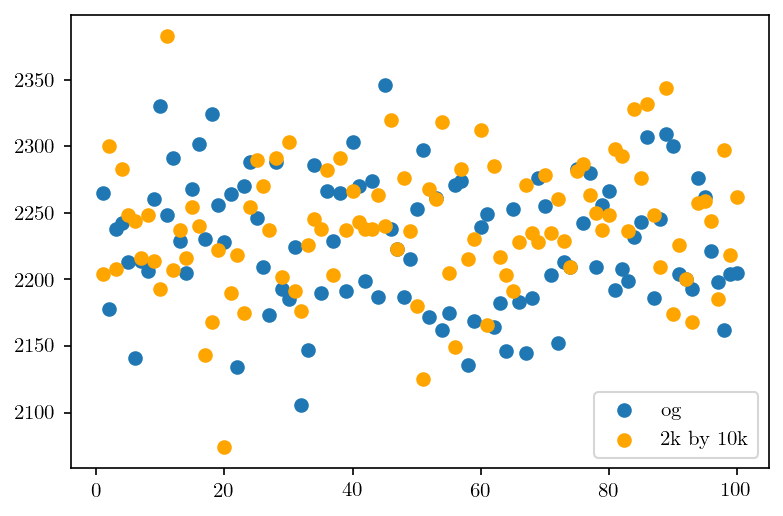

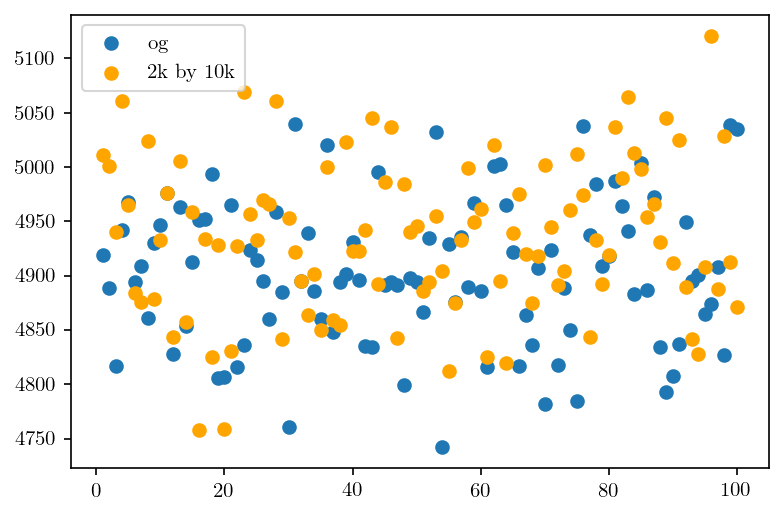

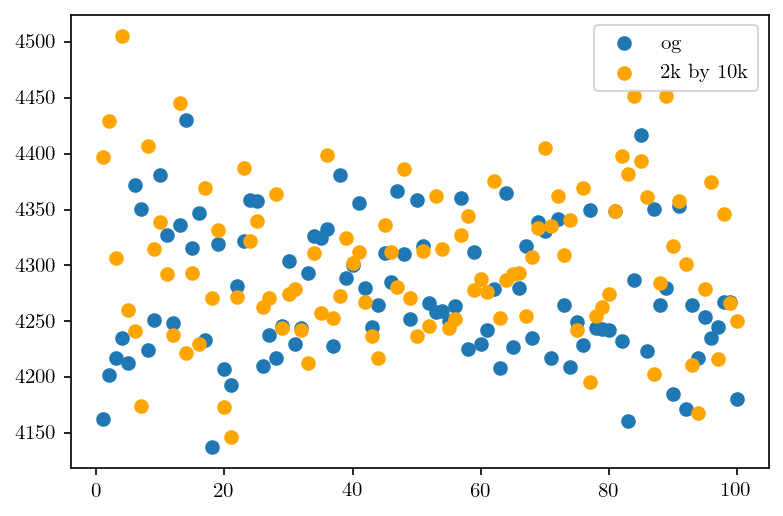

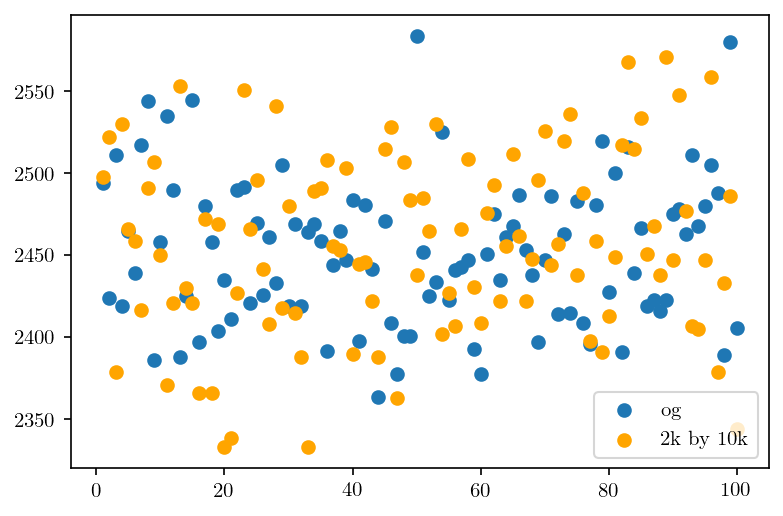

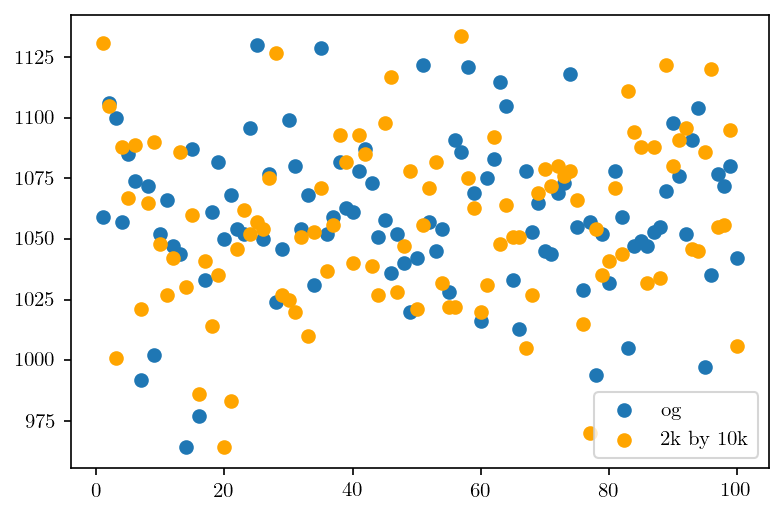

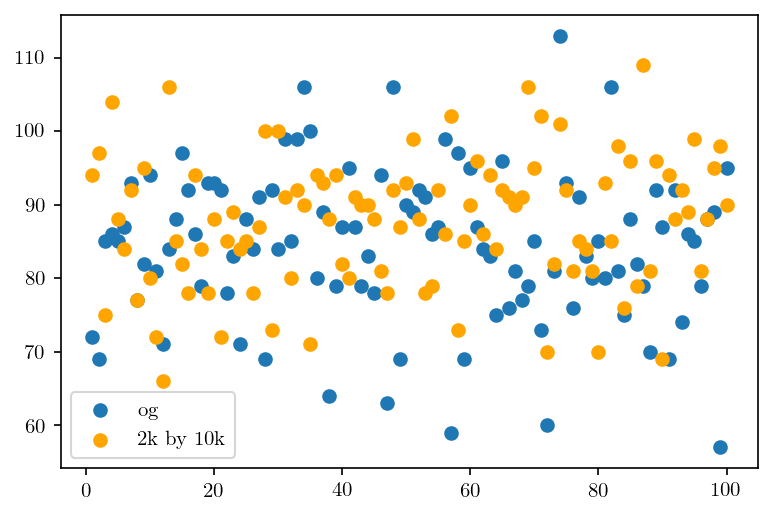

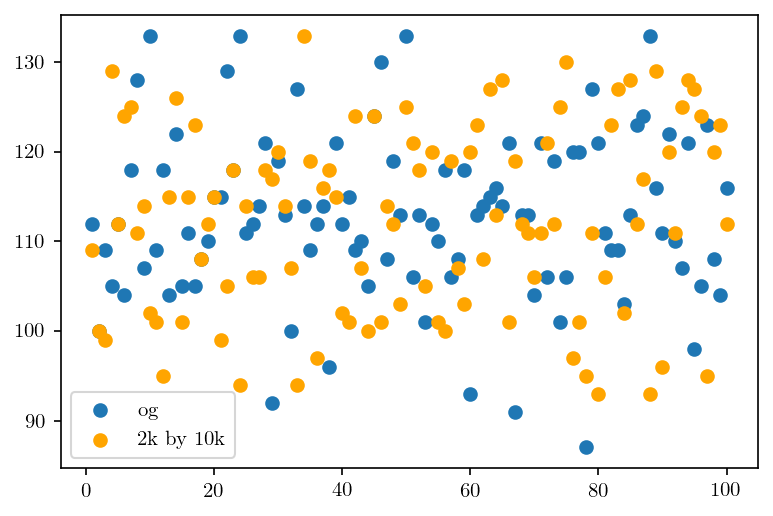

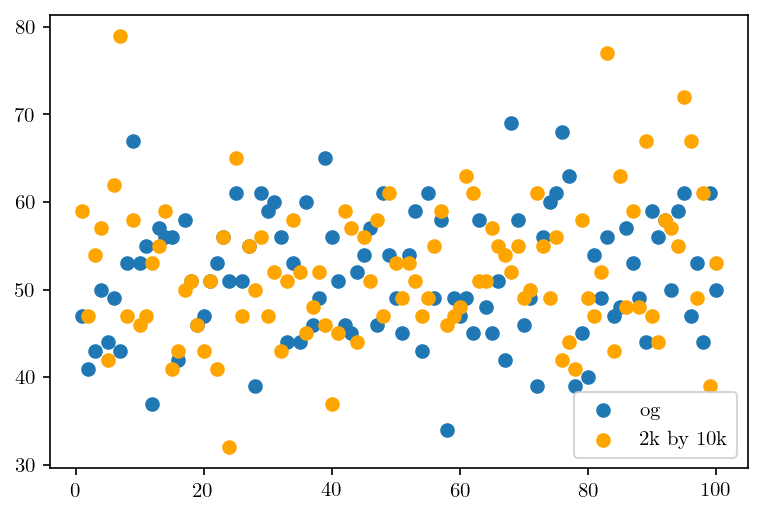

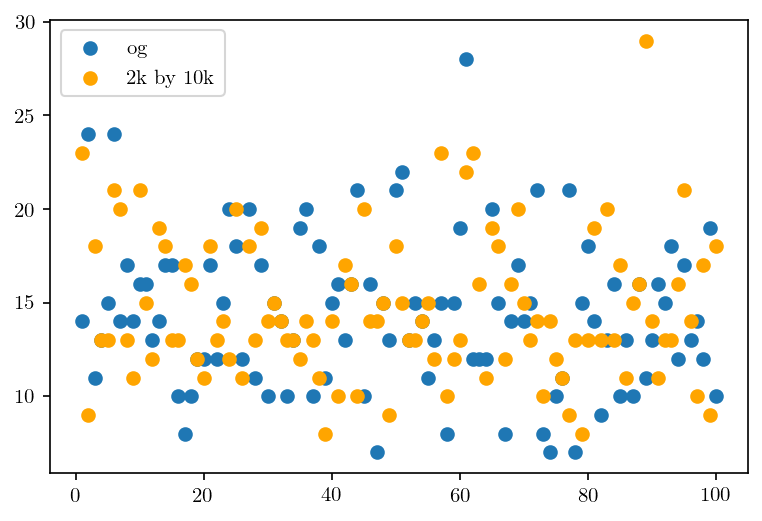

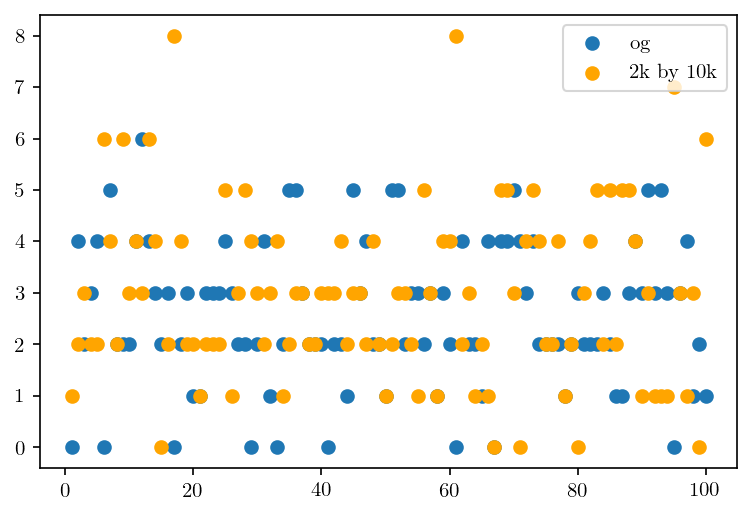

In [151]:
for i in range(N_counts1.shape[1]):
    plt.figure()
    plt.scatter(seeds, N_counts_th_1[:, i], label = 'og')
    plt.scatter(seeds, N_counts_th_2[:, i], label = '2k by 10k', c = 'orange')
    plt.legend(loc = 'best')

In [153]:
### different theta
theta_2 = np.array([0.1193, 0.78])

In [154]:
N_counts_th_3 = []
N_counts_th_4 = []
for i in range(100):
    N_counts_th_3.append(N_countsSimulator.simulation(theta_2, i))
    N_counts_th_4.append(N_countsSimulator_trial.simulation(theta_2, i))
    if i%10 == 0:
        print(i)
        
N_counts_th_3 = np.array(N_counts_th_3)
N_counts_th_4 = np.array(N_counts_th_4)

0
10
20
30
40
50
60
70
80
90


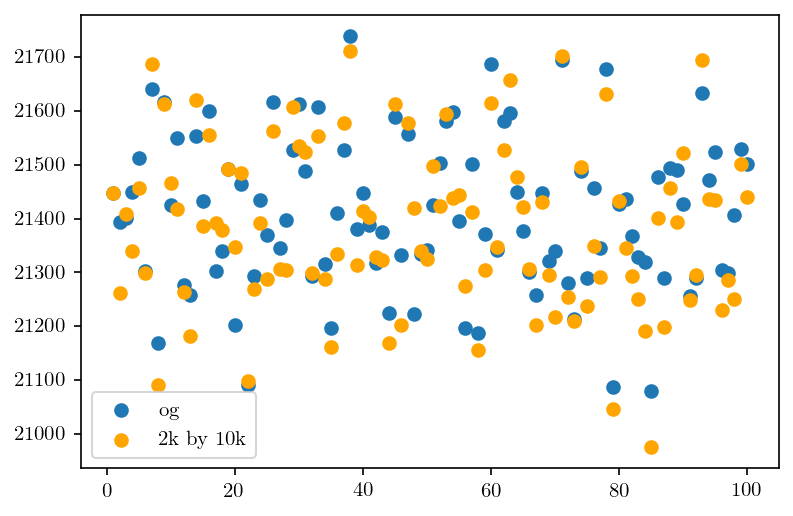

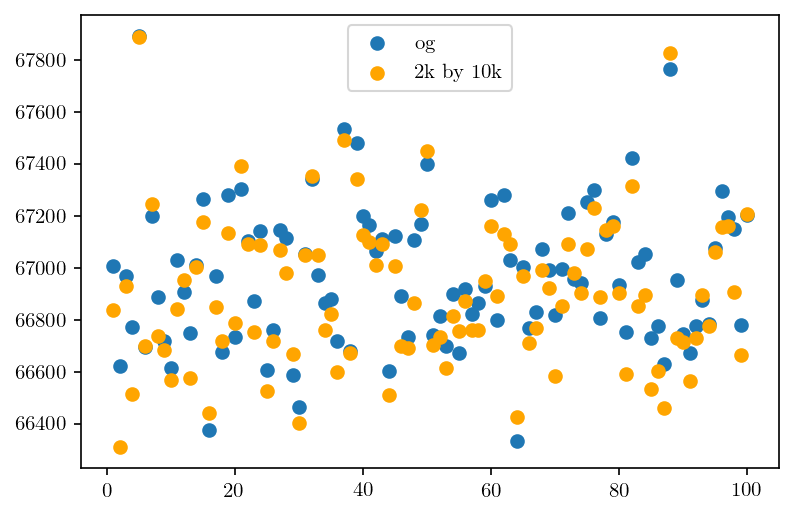

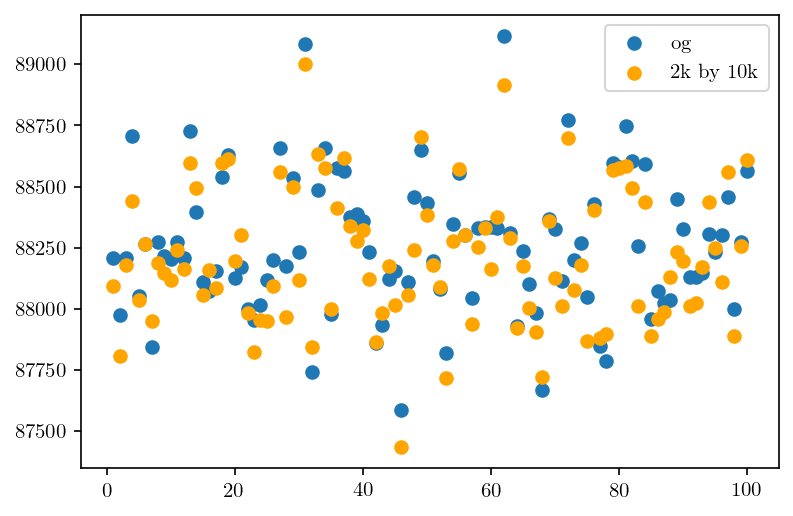

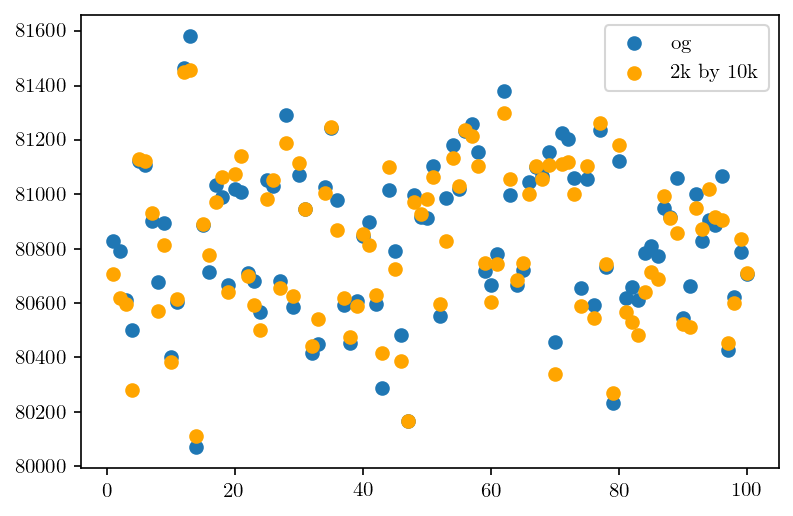

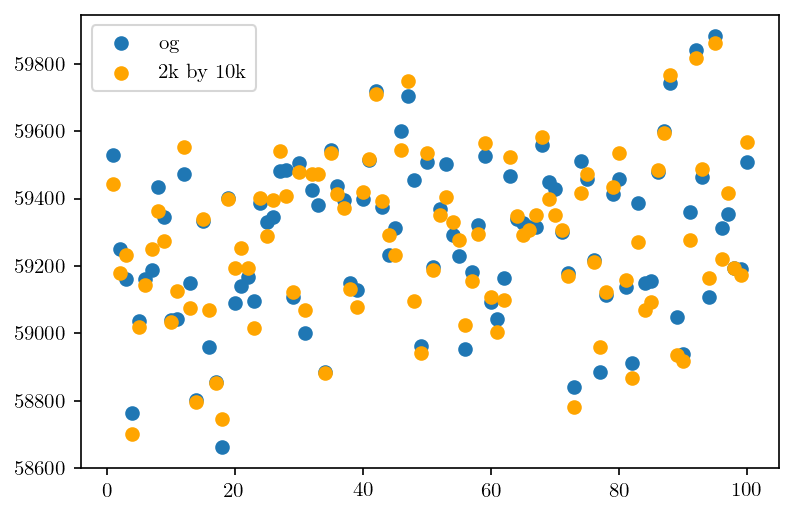

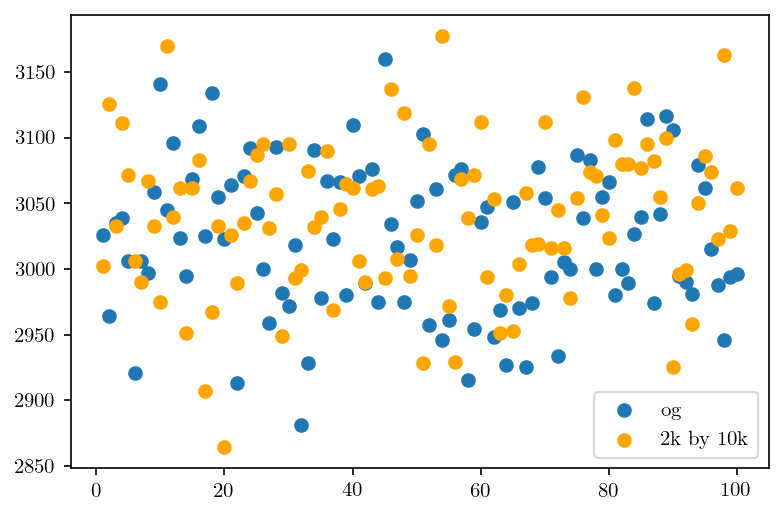

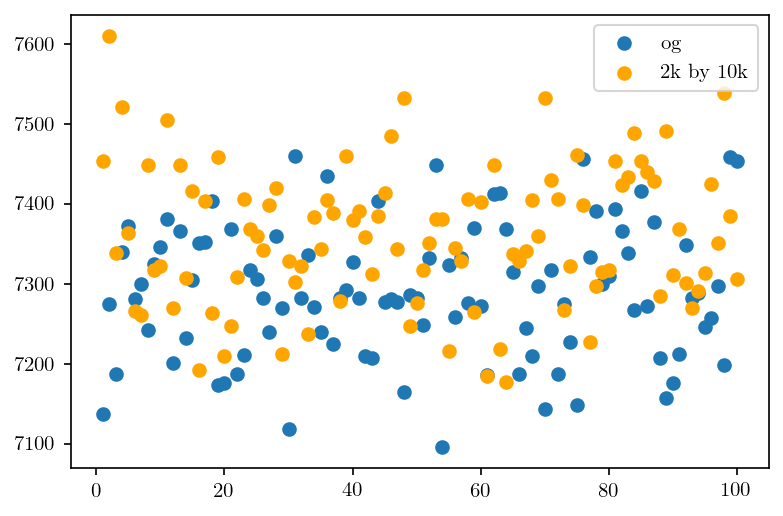

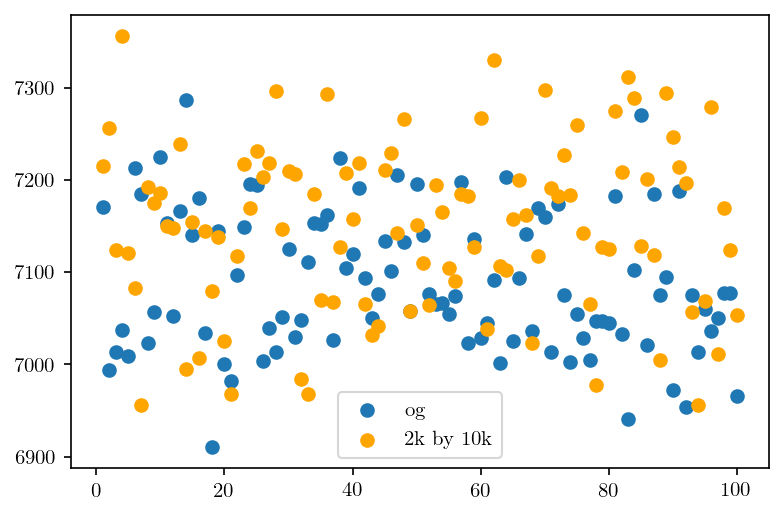

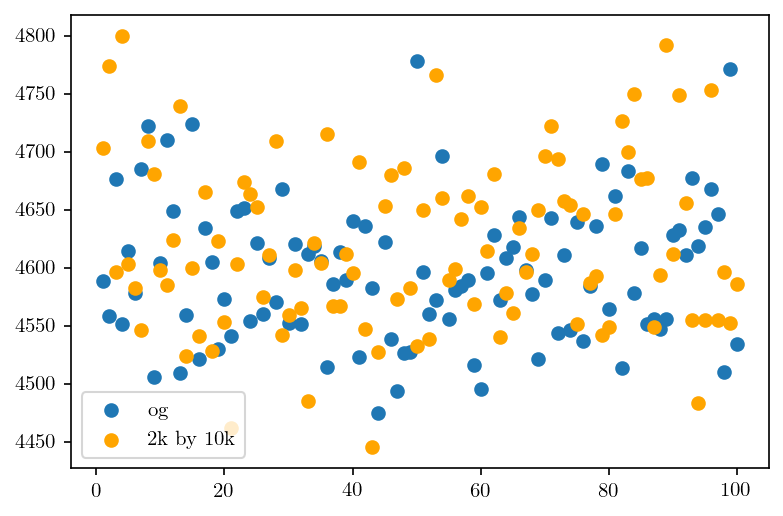

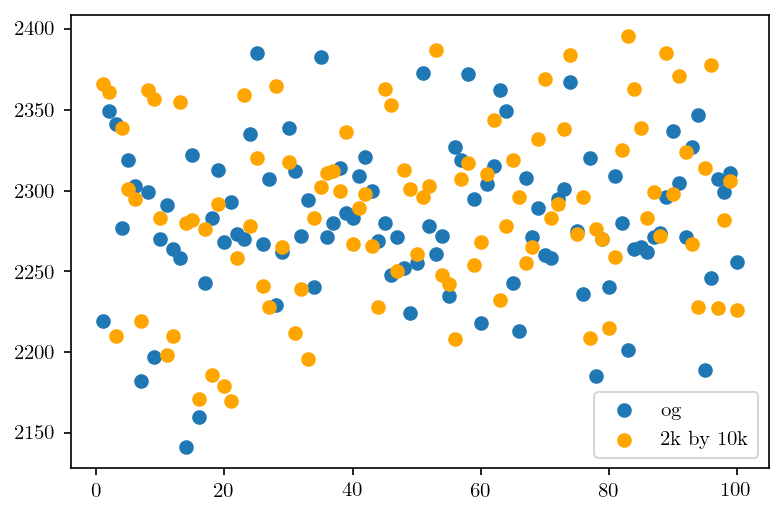

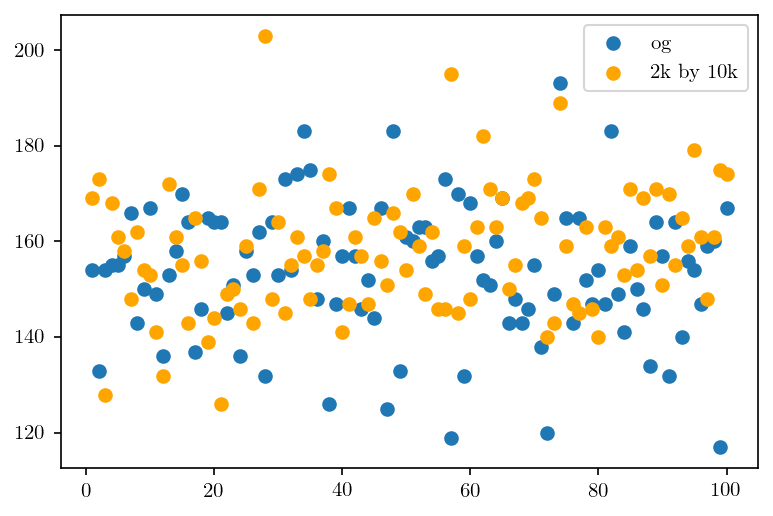

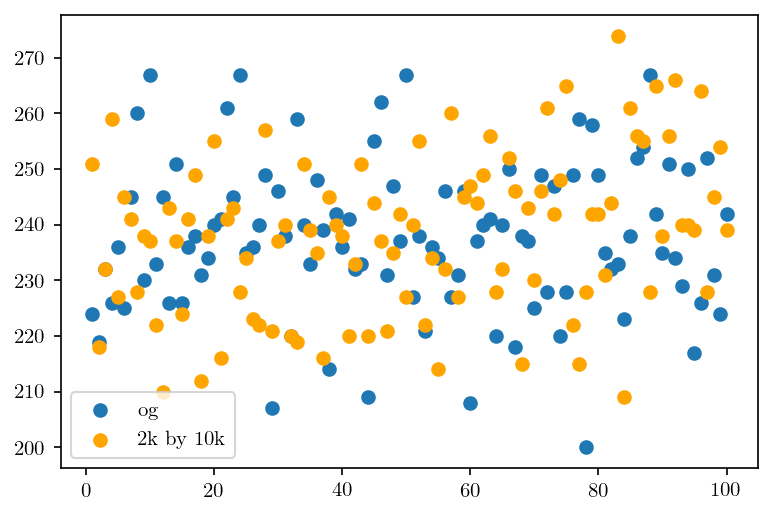

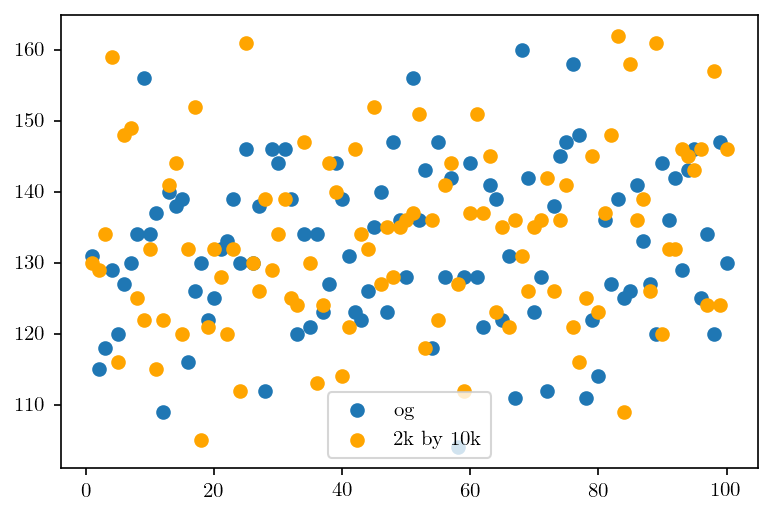

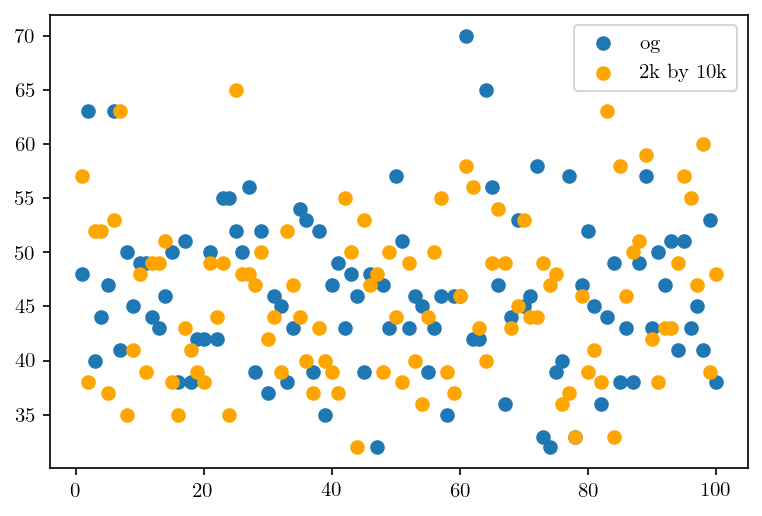

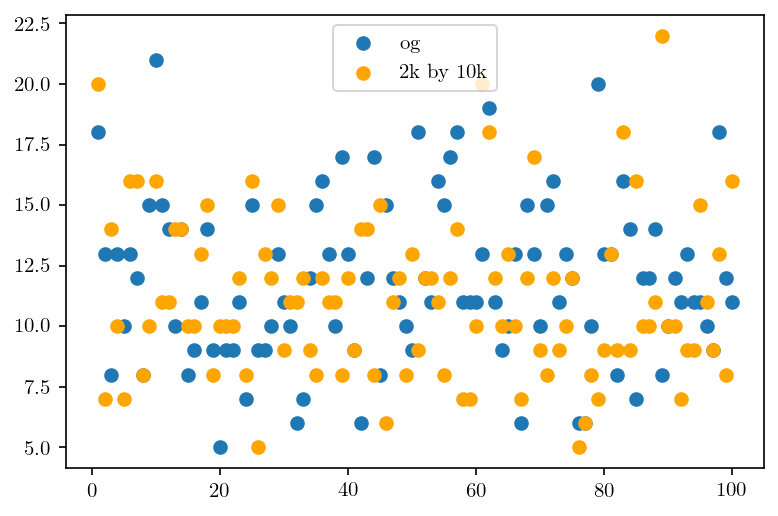

In [155]:
for i in range(N_counts1.shape[1]):
    plt.figure()
    plt.scatter(seeds, N_counts_th_3[:, i], label = 'og')
    plt.scatter(seeds, N_counts_th_4[:, i], label = '2k by 10k', c = 'orange')
    plt.legend(loc = 'best')